In [1]:
from scipy.io import loadmat
import os

dataset_path = '/home/micro/Anaiis/Dataset/SEED/SEED/ExtractedFeatures'
dataset_path2 = '/home/micro/Anaiis/Dataset/SEED/SEED/Preprocessed_EEG'
file_name = '6_20130712'
de_data = loadmat(os.path.join(dataset_path, file_name))
raw_data = loadmat(os.path.join(dataset_path2, file_name))

In [3]:
from scipy.io import loadmat
import os

data_path1 = "/data/Anaiis/Data/SEED_IV/eeg_feature_smooth/1/1_20160518"
data_path2 = "/data/Anaiis/Data/SEED_IV/eeg_raw_data/1/1_20160518"
feat = loadmat(data_path1)
raw = loadmat(data_path2)
# [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]

In [6]:
feat['de_LDS1'].shape

(62, 42, 5)

In [8]:
raw['cz_eeg1'].shape

(62, 33601)

In [4]:
raw.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24'])

In [7]:
tmp_de_feat = de_data['de_LDS' + str(1)]  # trial 1

In [14]:
de_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'de_movingAve1', 'de_LDS1', 'psd_movingAve1', 'psd_LDS1', 'dasm_movingAve1', 'dasm_LDS1', 'rasm_movingAve1', 'rasm_LDS1', 'asm_movingAve1', 'asm_LDS1', 'dcau_movingAve1', 'dcau_LDS1', 'de_movingAve2', 'de_LDS2', 'psd_movingAve2', 'psd_LDS2', 'dasm_movingAve2', 'dasm_LDS2', 'rasm_movingAve2', 'rasm_LDS2', 'asm_movingAve2', 'asm_LDS2', 'dcau_movingAve2', 'dcau_LDS2', 'de_movingAve3', 'de_LDS3', 'psd_movingAve3', 'psd_LDS3', 'dasm_movingAve3', 'dasm_LDS3', 'rasm_movingAve3', 'rasm_LDS3', 'asm_movingAve3', 'asm_LDS3', 'dcau_movingAve3', 'dcau_LDS3', 'de_movingAve4', 'de_LDS4', 'psd_movingAve4', 'psd_LDS4', 'dasm_movingAve4', 'dasm_LDS4', 'rasm_movingAve4', 'rasm_LDS4', 'asm_movingAve4', 'asm_LDS4', 'dcau_movingAve4', 'dcau_LDS4', 'de_movingAve5', 'de_LDS5', 'psd_movingAve5', 'psd_LDS5', 'dasm_movingAve5', 'dasm_LDS5', 'rasm_movingAve5', 'rasm_LDS5', 'asm_movingAve5', 'asm_LDS5', 'dcau_movingAve5', 'dcau_LDS5', 'de_movingAve6', 'de_LDS6

In [2]:
import numpy as np 
from scipy.signal import welch, butter, lfilter


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    [b, a] = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def filter_data(data, fs=200):
    print('data shape:', data.shape)
    chan, time = data.shape
    bands = 5
    filtered = np.zeros((chan, bands, time))
    filtered[:, 0, :] = butter_bandpass_filter(data, 1, 4, fs)
    filtered[:, 1, :] = butter_bandpass_filter(data, 4, 8, fs)
    filtered[:, 2, :] = butter_bandpass_filter(data, 8, 14, fs)
    filtered[:, 3, :] = butter_bandpass_filter(data, 14, 31, fs)
    filtered[:, 4, :] = butter_bandpass_filter(data, 31, 45, fs)
    print('filter shape:', filtered.shape)
    return filtered

window_len = 200
tmp_trial = raw_data['mhw_eeg1']
filtered = filter_data(tmp_trial)
trial_len = len(tmp_trial[1])
num_samples = trial_len // window_len
split_filter = np.reshape(filtered[:, :, :num_samples * window_len], (62, 5, num_samples, window_len))
# 62, 5, samples, window_len
split_filter = split_filter.transpose((2, 0, 1, 3))  # (sample, 62, 5, 20)
print(split_filter.shape)

data shape: (62, 47001)
filter shape: (62, 5, 47001)
(235, 62, 5, 200)


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
split_filter_norm = np.zeros((235, 62, 5, 200))
for chan in range(62):
    for band in range(5):
        split_filter_norm[:, chan, band, :] = scaler.fit_transform(split_filter[:, chan, band, :])



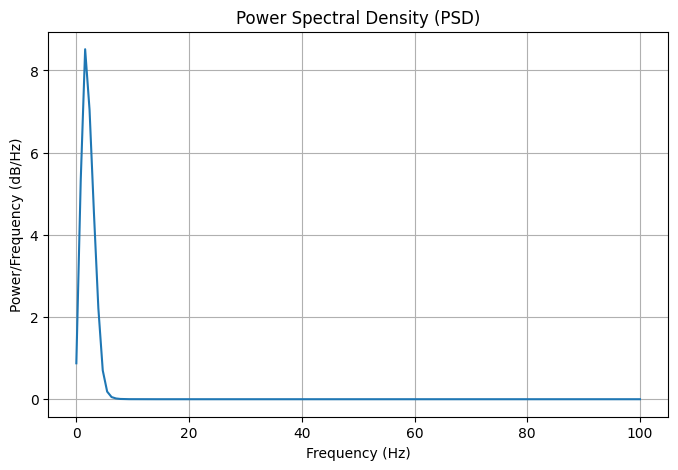

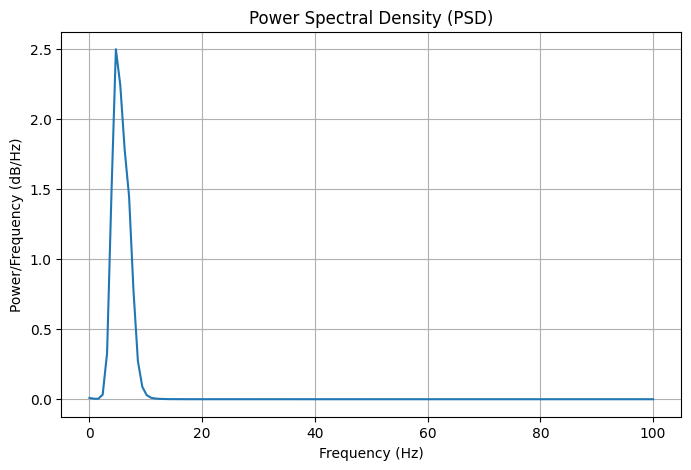

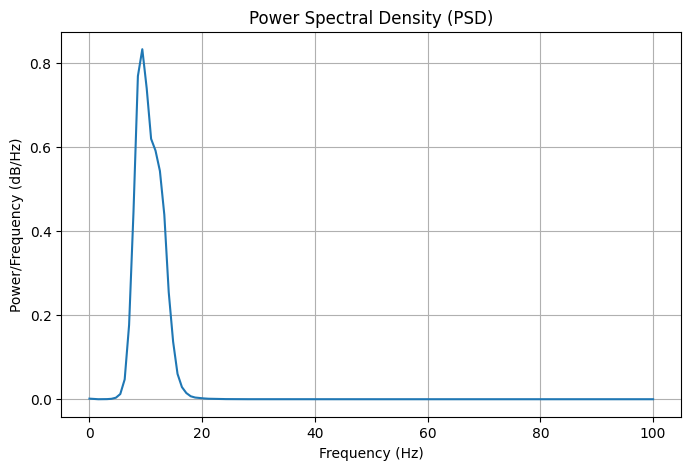

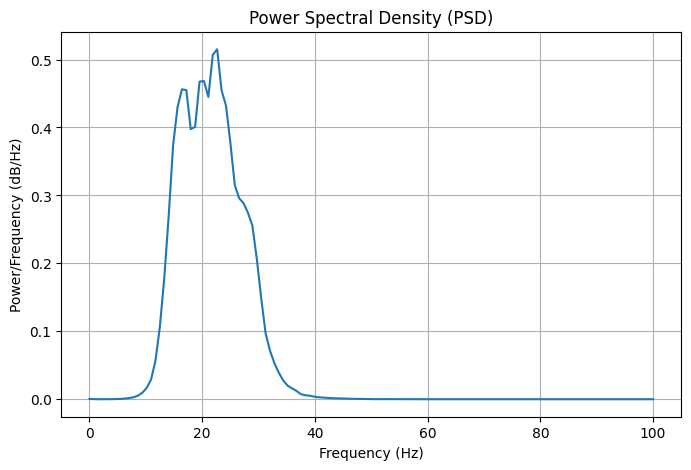

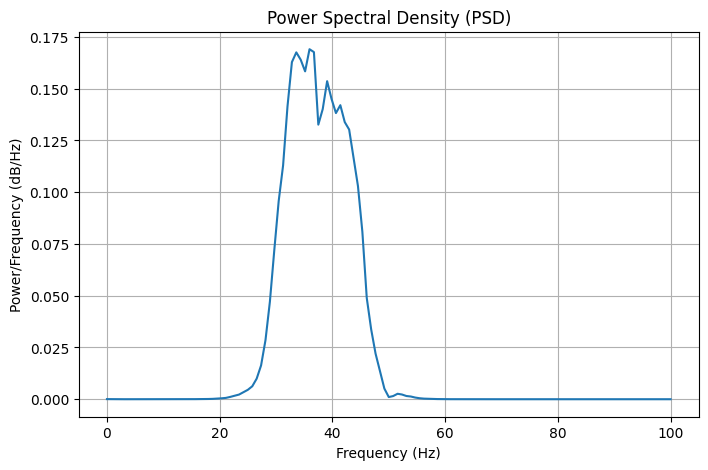

In [25]:
# PSD
from scipy.signal import welch
import matplotlib.pyplot as plt

fs = 200  
t = np.linspace(0, 10, fs*10) 
for band in range(5):
    signal = filtered[-1, band, :] #filtered(62, 5, 47001)
    # print(filtered.shape)

    frequencies, psd = welch(signal, fs)  #, nperseg=1024
    log_psd = np.log(psd)
    # 绘制功率谱密度 (PSD)
    plt.figure(figsize=(8, 5))
    plt.plot(frequencies, psd)
    # plt.plot(log_psd)
    plt.title('Power Spectral Density (PSD)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid(True)
    # plt.show()


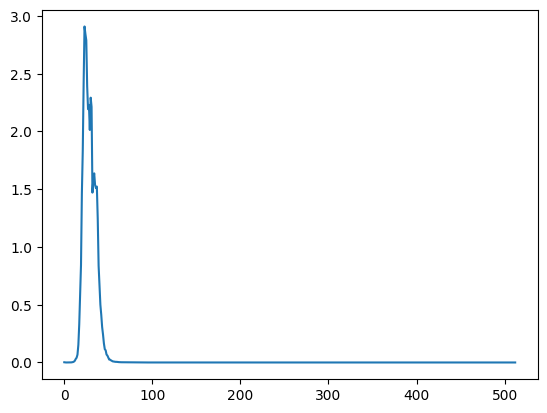

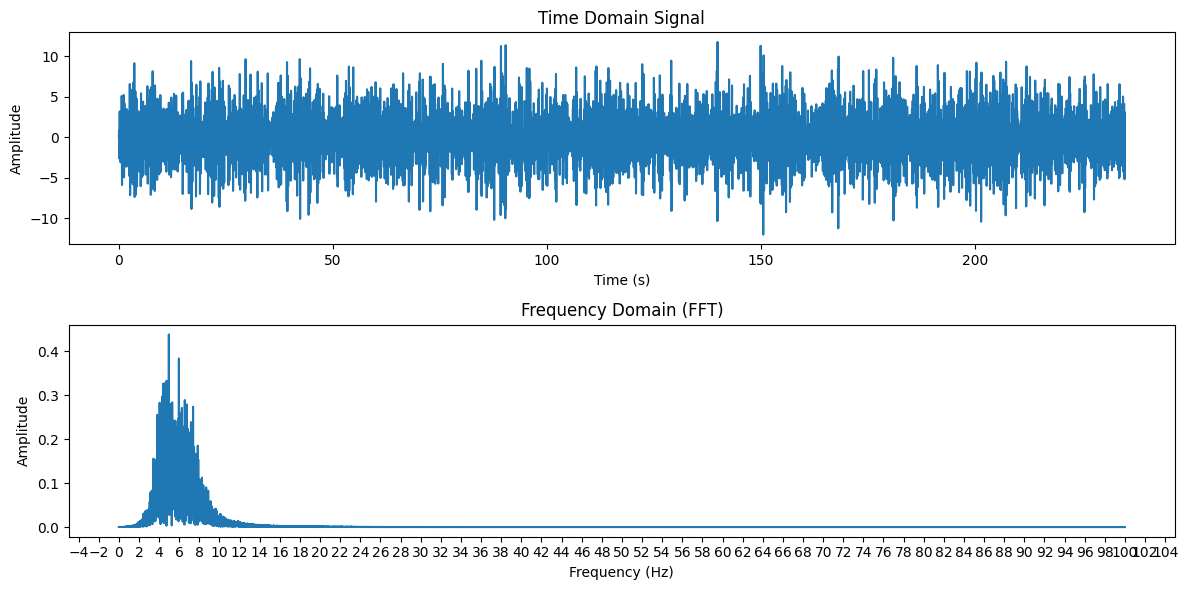

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from matplotlib.ticker import MultipleLocator


fs = 200  # 采样频率 (Hz)
T = 1.0 / fs  # 采样周期
N = 47001  
t = np.linspace(0.0, N*T, N, endpoint=False)  # 时间序列

signal = filtered[-1, 1, :]
yf = fft(signal)
xf = fftfreq(N, T)[:N//2]  # 频率坐标

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Time Domain Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 绘制频域图
plt.subplot(2, 1, 2)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Frequency Domain (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.gca().xaxis.set_major_locator(MultipleLocator(2)) 
# 显示图像
plt.tight_layout()
plt.show()


In [5]:
split_filter_plt = split_filter.mean(axis=3)
split_filter_plt.shape

(235, 62, 5)

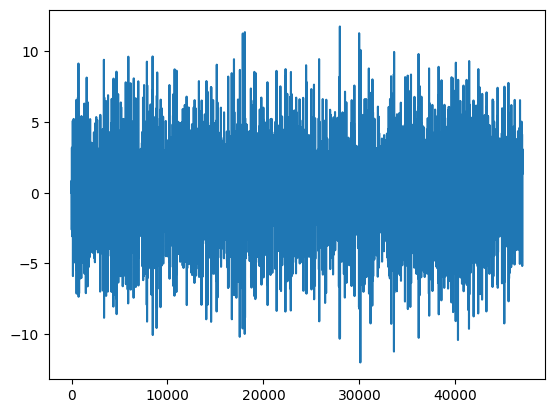

In [6]:
plt.plot(filtered[-1, 1, :])

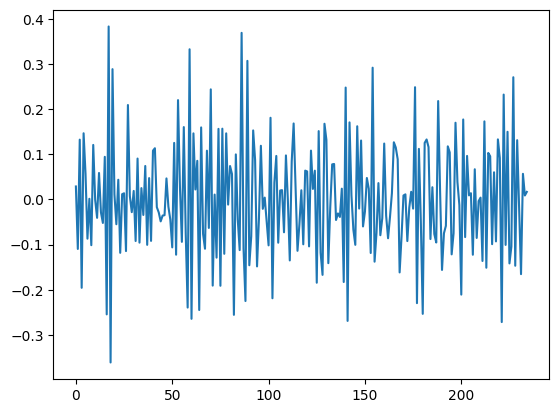

In [36]:
plt.plot(split_filter_plt[:, -1, 1])

In [11]:
import math

def compute_DE(signal):
    variance = np.var(signal)  # ddof=1 无偏估计，ddof default 正态分布方差的最大似然估计
    return math.log(2 * math.pi * math.e * variance+1e-6) / 2

de_res = np.zeros((62, 235, 5))
for sample in range(235):
    for chan in range(62):
        for band in range(5):
            de_res[chan, sample, band] = compute_DE(split_filter_norm[sample, chan, band, :])

# de_res

In [35]:
de_res

array([[[-0.40305716, -0.40762485, -0.38685901, -0.42437106,
         -0.2765762 ],
        [-0.31503085, -0.36731311, -0.24818076,  0.09054744,
         -0.08984854],
        [-0.22023454, -0.35550328, -0.21896324, -0.23436399,
         -0.25687941],
        ...,
        [ 0.0709739 , -0.2730918 , -0.33209554, -0.52394167,
         -0.60889115],
        [-0.24192782, -0.27526223, -0.65814622, -0.64240561,
         -0.67112196],
        [-0.1987065 , -0.31220813, -0.48059226, -0.59556552,
         -0.62566503]],

       [[-0.3518676 , -0.49015846, -0.24990048, -0.30430075,
         -0.39056988],
        [-0.28127769, -0.46696432, -0.24180767, -0.05276329,
         -0.29555849],
        [-0.35454558, -0.45900761, -0.18846414, -0.14870504,
         -0.29311892],
        ...,
        [-0.03011903, -0.44027581, -0.26636096, -0.34984347,
         -0.70523571],
        [-0.20711695, -0.35609484, -0.7661563 , -0.4297923 ,
         -0.56750048],
        [-0.28366765, -0.37600716, -0.34047567, 

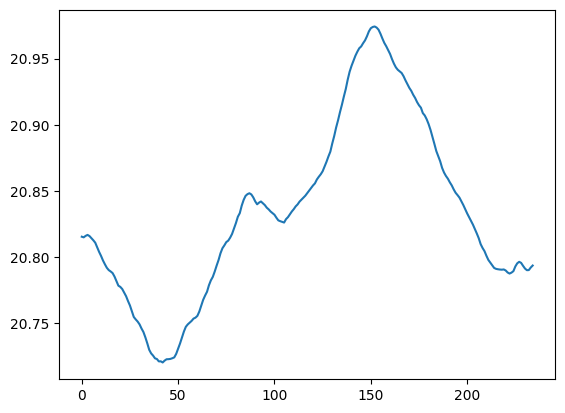

In [8]:
import matplotlib.pyplot as plt

plt.plot(tmp_de_feat[-1, :, 1])
# np.save("sig.npy", tmp_de_feat[-1, :, 1])
# plt.plot(de_res[-1, :, 2])
# de_res[-1]

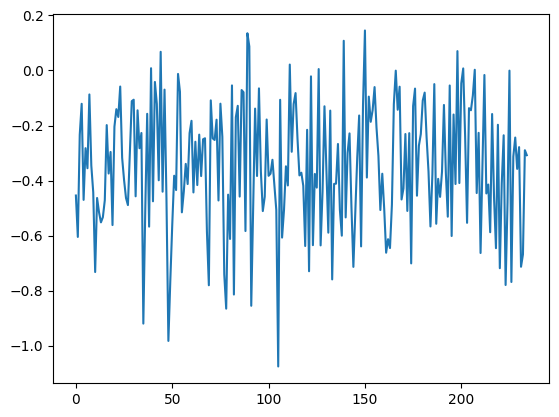

In [12]:
plt.plot(de_res[-1, :, 1])
# np.save("my_sig.npy", de_res[-1, :, 1])

235 235


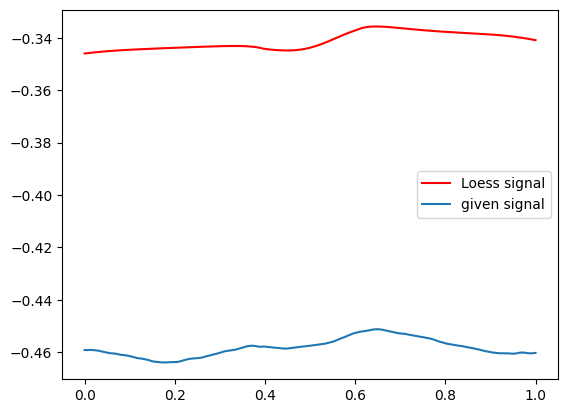

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# 生成示例信号
x = np.linspace(0, 1, 235)
signal = de_res[-1, :, 1]
print(len(signal), len(x))
# 应用Loess滤波
smoothed_signal = lowess(signal, x, frac=0.8)  # frac是平滑参数

# 绘图
# plt.plot(x, signal, label='original')
plt.plot(smoothed_signal[:, 0], smoothed_signal[:, 1], color='red', label='Loess signal')
plt.plot(x, tmp_de_feat[-1, :, 1]/20-1.5, label='given signal')
plt.legend()
plt.show()

/home/micro/anaconda3/envs/bob_env1/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


[[ 0.         -0.34948152]
 [ 0.0042735  -0.35588022]
 [ 0.00854701 -0.36246106]
 [ 0.01282051 -0.36899625]
 [ 0.01709402 -0.37527397]
 [ 0.02136752 -0.38114839]
 [ 0.02564103 -0.386462  ]
 [ 0.02991453 -0.39109638]
 [ 0.03418803 -0.39502459]
 [ 0.03846154 -0.3984894 ]
 [ 0.04273504 -0.40227623]
 [ 0.04700855 -0.40837018]
 [ 0.05128205 -0.40860401]
 [ 0.05555556 -0.40587278]
 [ 0.05982906 -0.39952736]
 [ 0.06410256 -0.39054378]
 [ 0.06837607 -0.38014862]
 [ 0.07264957 -0.36877014]
 [ 0.07692308 -0.35679519]
 [ 0.08119658 -0.34412498]
 [ 0.08547009 -0.33523502]
 [ 0.08974359 -0.32344684]
 [ 0.09401709 -0.31035425]
 [ 0.0982906  -0.296911  ]
 [ 0.1025641  -0.28366793]
 [ 0.10683761 -0.27097994]
 [ 0.11111111 -0.25902345]
 [ 0.11538462 -0.24782098]
 [ 0.11965812 -0.23726463]
 [ 0.12393162 -0.22714891]
 [ 0.12820513 -0.21725571]]
[[ 0.0042735  -0.32942232]
 [ 0.00854701 -0.33890418]
 [ 0.01282051 -0.34809903]
 [ 0.01709402 -0.35682254]
 [ 0.02136752 -0.36496059]
 [ 0.02564103 -0.37238169]


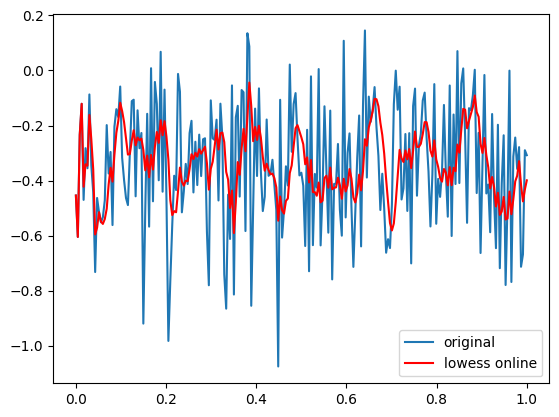

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

x = np.linspace(0, 1, 235)
signal = de_res[-1, :, 1]

# 在线滤波的Loess实现
smoothed_signal = []
buffer_size = 30 

for i in range(len(signal)):
    if i < buffer_size:
        smoothed_value = lowess(signal[:i+1], x[:i+1], frac=0.8)
    else:
        smoothed_value = lowess(signal[i-buffer_size:i+1], x[i-buffer_size:i+1], frac=0.8)
        print(smoothed_value)
    smoothed_signal.append(smoothed_value[-1, 1])

# 绘图
plt.plot(x, signal, label='original')
plt.plot(x, smoothed_signal, color='red', label='lowess online')
plt.legend()
plt.show()


In [13]:
pip install statsmodels

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 18.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
from pykalman import KalmanFilter


def smoothing(extracted, win_len=20):
    num_window = int(extracted.shape[0]/win_len)
    N_chan, N_band = extracted.shape[1], extracted.shape[2]
    filtered = None
    win_filtered = np.zeros((win_len, N_chan, N_band))
    for n in range(num_window):
        print(n)
        window = extracted[n*win_len:(n+1)*win_len, :, :]
        for channel in range(N_chan):
            for band in range(N_band):
                kf = KalmanFilter(initial_state_mean=np.mean(window[:, channel, band]),
                                  observation_covariance=10, transition_covariance=0.1)
                (filtered_c, _) = kf.smooth(window[:, channel, band])
                win_filtered[:, channel, band] = filtered_c[:, 0]

        if filtered is None:
            filtered = win_filtered
        else:
            filtered = np.concatenate((filtered, win_filtered))
        print(filtered.shape)
    return filtered

de_res2 = de_res.reshape((235, 62, 5))
filtered = smoothing(de_res2, win_len=20)
print(filtered.shape)

0
(20, 62, 5)
1
(40, 62, 5)
2
(60, 62, 5)
3
(80, 62, 5)
4
(100, 62, 5)
5
(120, 62, 5)
6
(140, 62, 5)
7
(160, 62, 5)
8
(180, 62, 5)
9
(200, 62, 5)
10
(220, 62, 5)
(220, 62, 5)


In [28]:
de_res.shape

(62, 235, 5)

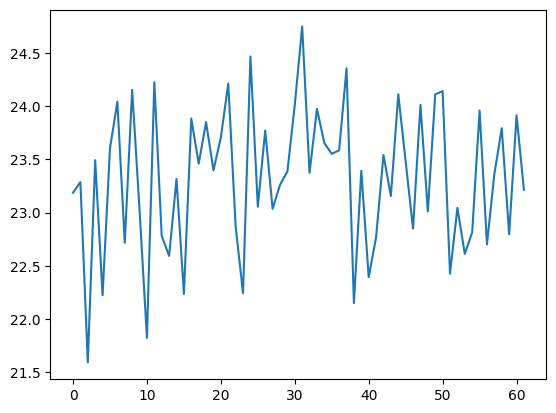

In [31]:
plt.plot(filtered[-1, :, 1]*10)

In [52]:
import numpy as np

# Load the provided signal data
my_sig_path = './my_sig.npy'
sig_path = './sig.npy'

my_sig = np.load(my_sig_path)
sig = np.load(sig_path)

# Check the shapes and basic statistics of both signals
my_sig_shape = my_sig.shape
sig_shape = sig.shape

my_sig_stats = {
    "mean": np.mean(my_sig),
    "std": np.std(my_sig),
    "min": np.min(my_sig),
    "max": np.max(my_sig)
}

sig_stats = {
    "mean": np.mean(sig),
    "std": np.std(sig),
    "min": np.min(sig),
    "max": np.max(sig)
}

(my_sig_shape, sig_shape, my_sig_stats, sig_stats)


((235,),
 (235,),
 {'mean': 4.829132739958091,
  'std': 0.5410060734392753,
  'min': 2.9984914565081957,
  'max': 6.252438526267126},
 {'mean': 20.833762454024875,
  'std': 0.06810287528204977,
  'min': 20.72042692699397,
  'max': 20.97431494294655})

In [37]:
from pykalman import KalmanFilter

# Setting up the Kalman Filter for smoothing (LDS filter)
# Use empirical values for initial mean and covariance estimates
initial_state_mean = my_sig[0]
observation_covariance = 0.5  # Rough estimation of observation noise
transition_covariance = 0.1    # Rough estimation of process noise

# Create a Kalman Filter instance
kf = KalmanFilter(
    initial_state_mean=initial_state_mean,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance
)

# Apply smoothing to my_sig using the Kalman Filter
my_sig_smoothed, _ = kf.smooth(my_sig)


NameError: name 'my_sig' is not defined

In [38]:
plt.plot(my_sig_smoothed)

NameError: name 'my_sig_smoothed' is not defined

In [64]:
def exponential_moving_average(signal, alpha):
    smoothed_signal = np.zeros_like(signal)
    smoothed_signal[0] = signal[0]  # Initialize the first value
    for i in range(1, len(signal)):
        smoothed_signal[i] = alpha * signal[i] + (1 - alpha) * smoothed_signal[i - 1]
    return smoothed_signal

# Apply EMA smoothing to the signal with a chosen alpha (smoothing factor)
alpha = 0.1
my_sig_smoothed = exponential_moving_average(my_sig, alpha)

# Check the statistics of the smoothed signal
my_sig_smoothed_stats = {
    "mean": np.mean(my_sig_smoothed),
    "std": np.std(my_sig_smoothed),
    "min": np.min(my_sig_smoothed),
    "max": np.max(my_sig_smoothed)
}

my_sig_smoothed_stats

{'mean': 4.818491837099736,
 'std': 0.13464529534712671,
 'min': 4.3727151296527,
 'max': 5.175311134392942}

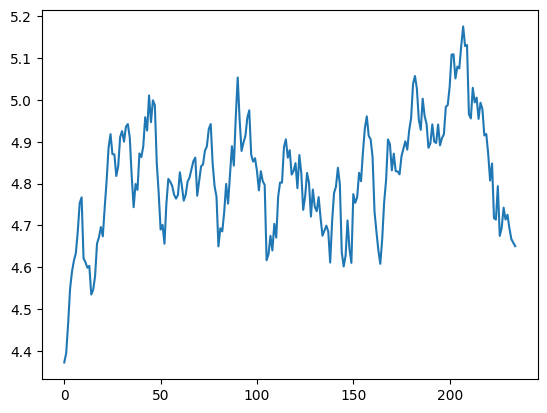

In [65]:
plt.plot(my_sig_smoothed)